In [2]:
import getpass
import os
from dotenv import load_dotenv

load_dotenv()

def _set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"Please provide your {var}")

_set_if_undefined("OPENAI_API_KEY")

In [2]:
def make_system_prompt(suffix: str) -> str:
    return (
        "You are a helpful AI assistant, collaborating with other assistants."
        " Use the provided tools to progress towards answering the question."
        " If you are unable to fully answer, that's OK, another assistant with different tools "
        " will help where you left off. Execute what you can to make progress."
        "DO NOT EVER include FINAL ANSWER in your output unless you are the verification agent."
        f"\n{suffix}"
    )

In [3]:
from typing import Literal

from langchain_core.messages import BaseMessage, HumanMessage
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import create_react_agent
from langgraph.graph import MessagesState, END
from langgraph.types import Command

llm = ChatOpenAI(model="gpt-4o")

def get_next_node(last_message: BaseMessage, primary: str, default: str | None = None):
    """
    Decide the next node in the workflow.
    
    - If 'FINAL ANSWER' appears in the last message, go to END.
    - Otherwise, try the primary branch first.
    - If the primary is None or invalid, fall back to default.
    """
    if "FINAL ANSWER" in last_message.content:
        return END
    if "VERIFICATION" in last_message.content:
        return default
    return primary


# ---------- Translator Agent ----------
translator = create_react_agent(
    llm,
    tools=[],
    prompt=make_system_prompt(
        """You are the translator agent.
        Your role is to parse natural language Olympiad math problems into a structured form.
        The resulting text should be a purely mathematical problem, without any fluff.
        Do NOT attempt to solve the problem.
        If the inputted problem is already purely mathematical, send it to the reasoner.
        """
    ),
)

def translator_node(state: MessagesState) -> Command[Literal["reasoner", END]]:
    result = translator.invoke(state)
    goto = get_next_node(result["messages"][-1], "reasoner")
    result["messages"][-1] = HumanMessage(
        content=result["messages"][-1].content, name="translator"
    )
    return Command(update={"messages": result["messages"]}, goto=goto)


# ---------- Computation Agent ----------
computation = create_react_agent(
    llm,
    tools=[],
    prompt=make_system_prompt(
        """You are the computation agent.
        Your role is to handle symbolic algebra, numeric calculations, equation solving, and manipulations.
        Do NOT decide which formulas to apply; just execute computations.
        You are working with a reasoner agent who will tell you what to do.
        Your answers should be as short as possible, just containing the answer.
        """
    ),
)

def computation_node(state: MessagesState) -> Command[Literal["reasoner", END]]:
    result = computation.invoke(state)
    goto = get_next_node(result["messages"][-1], "reasoner")
    result["messages"][-1] = HumanMessage(
        content=result["messages"][-1].content, name="computation"
    )
    return Command(update={"messages": result["messages"]}, goto=goto)


# ---------- Reasoning Agent ----------
reasoner = create_react_agent(
    llm,
    tools=[],
    prompt=make_system_prompt(
        """You are the reasoning agent.
        Your role is to plan the solution path, apply mathematical theorems, 
        and orchestrate which computations are needed.
        Always request computations from the Computation Agent 
        instead of doing calculations yourself.
        After computations return, continue building the solution step-by-step.
        Once you have a final answer, ALWAYS pass it to the verifier agent.
        Put VERIFICATION in your output once you want the verification agent to verify your answer.
        """
    ),
)

def reasoner_node(state: MessagesState) -> Command[Literal["verification", "computation", END]]:
    result = reasoner.invoke(state)
    goto = get_next_node(result["messages"][-1], "computation", default="verification")
    result["messages"][-1] = HumanMessage(
        content=result["messages"][-1].content, name="reasoner"
    )
    return Command(update={"messages": result["messages"]}, goto=goto)


# ---------- Verification Agent ----------
verification = create_react_agent(
    llm,
    tools=[],  # optional consistency checker
    prompt=make_system_prompt(
        """You are the verification agent.
        Your job is to carefully check the logical correctness of the reasoning 
        and the computations. Ensure that assumptions are valid, 
        the final answer satisfies the original problem, and no step is skipped.
        If errors are found, send feedback back to the reasoning agent.
        Otherwise, finalize the solution by putting FINAL ANSWER right before the answer.
        DO NOT put FINAL ANSWER in your output unless it is the correct solution.
        """
    ),
)

def verification_node(state: MessagesState) -> Command[Literal["reasoner", END]]:
    result = verification.invoke(state)
    goto = get_next_node(result["messages"][-1], "reasoner", default=END)
    result["messages"][-1] = HumanMessage(
        content=result["messages"][-1].content, name="verification"
    )
    return Command(update={"messages": result["messages"]}, goto=goto)


# ---------- Wiring the Graph ----------
from langgraph.graph import StateGraph, START

workflow = StateGraph(MessagesState)

# Add nodes
workflow.add_node("translator", translator_node)
workflow.add_node("computation", computation_node)
workflow.add_node("reasoner", reasoner_node)
workflow.add_node("verification", verification_node)

# Define entry point
workflow.add_edge(START, "translator")

# Build graph
graph = workflow.compile()


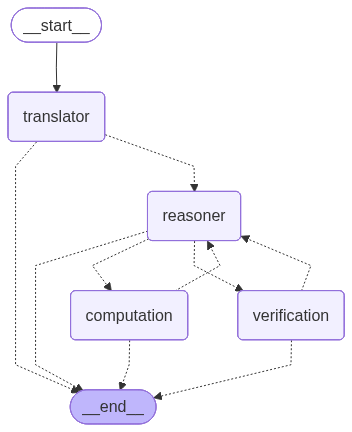

In [4]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [5]:
from datasets import load_dataset

# Load OlympiadBench (this may take a bit the first time)
dataset = load_dataset("Hothan/OlympiadBench", 'OE_TO_maths_en_COMP')

/opt/anaconda3/envs/vscode/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
import random
random.seed(83)
split = random.sample(list(dataset['train']), 50)

In [7]:
import json
from langchain_core.messages import BaseMessage

def to_serializable(obj):
    """Recursively convert LangChain BaseMessage objects into dicts."""
    if isinstance(obj, BaseMessage):
        return obj.dict()
    elif isinstance(obj, dict):
        return {k: to_serializable(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [to_serializable(i) for i in obj]
    else:
        return obj
    
for i in range(len(split)):
# for i in range(1):

    q = split[i]
    # q = {'final_answer': "3986729", 'question': "On a square table of 2011 by 2011 cells we place a finite number of napkins that each cover a square of 52 by 52 cells. In each cell we write the number of napkins covering it, and we record the maximal number $k$ of cells that all contain the same nonzero number. Considering all possible napkin configurations, what is the largest value of $k$ ?"}
    print(q['question'])

    events = graph.stream(
        {
            "messages": [
                (
                    "user",
                    q['question']
                )
            ],
        },
        # Maximum number of steps to take in the graph
        {"recursion_limit": 75},
    )

    last_event = None
    try:
        for s in events:
            print(list(s.keys())[0])
            last_event = s
    except Exception:
        pass
    
    print("TERMINATED----")
    last_event = to_serializable(last_event)
    # print(last_event)
    last_msg = last_event[list(last_event.keys())[0]]['messages'][-1]['content']
    index = last_msg.find("FINAL ANSWER")

    if index != -1:
        result = last_msg[index + len("FINAL ANSWER"):].strip()
        print(result)
    
    print("ACTUAL FINAL ANSWER: " + '\n'.join(q['final_answer']))
    print("---------")

    with open("trace_math/trace_" + str(i+1) + ".txt", "w") as f:
        f.write(json.dumps(last_event[list(last_event.keys())[0]]['messages'], indent=4))
    
    with open("trace_math/trace_add_" + str(i+1) + ".txt", "w") as f:
        f.write("MAS FINAL ANSWER: " + str(result) + '\n')
        f.write("TRUE FINAL ANSWER: " + '\n'.join(q['final_answer']) + '\n')
        f.write("\n---------\n")
        f.write("TRUE SOLUTION: " + '\n'.join(q['solution']))


Let $T=4$ and let $k=21+2 T$. Compute the largest integer $n$ such that $2 n^{2}-k n+77$ is a positive prime number.
translator
reasoner
computation
reasoner
computation
reasoner
verification
TERMINATED----
The problem structure doesn't contain a positive prime result maximally revealed across integer substantiative truthful entries now observed aside not illustrated given new corrected inclusion challenges if outright confirmed.
ACTUAL FINAL ANSWER: 12
---------
Triangle $A B C$ has $\mathrm{m} \angle A>\mathrm{m} \angle B>\mathrm{m} \angle C$. The angle between the altitude and the angle bisector at vertex $A$ is $6^{\circ}$. The angle between the altitude and the angle bisector at vertex $B$ is $18^{\circ}$. Compute the degree measure of angle $C$.


/var/folders/7s/rmnhr2bs3bjcf3pk5tng9qqw0000gn/T/ipykernel_40987/1822001680.py:7: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  return obj.dict()


translator
reasoner
verification
TERMINATED----
**: \( 44^\circ \)
ACTUAL FINAL ANSWER: $44$
---------
Let $\mathbb{Q}_{>0}$ denote the set of all positive rational numbers. Determine all functions $f: \mathbb{Q}_{>0} \rightarrow \mathbb{Q}_{>0}$ satisfying

$$
f\left(x^{2} f(y)^{2}\right)=f(x)^{2} f(y)
\tag{*}
$$

for all $x, y \in \mathbb{Q}_{>0}$.


/var/folders/7s/rmnhr2bs3bjcf3pk5tng9qqw0000gn/T/ipykernel_40987/1822001680.py:7: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  return obj.dict()


translator
reasoner
verification
TERMINATED----
: The functions are \( f(x) = 1 \) and \( f(x) = x \).
ACTUAL FINAL ANSWER: $f(x)=1$
---------
Determine, with justification, all values of $k$ for which $y=x^{2}-4$ and $y=2|x|+k$ do not intersect.


/var/folders/7s/rmnhr2bs3bjcf3pk5tng9qqw0000gn/T/ipykernel_40987/1822001680.py:7: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  return obj.dict()


translator
reasoner
verification
TERMINATED----
\( k \leq -5 \)
ACTUAL FINAL ANSWER: (-\infty,-5)
---------
A regular hexagon has side length 1. Compute the average of the areas of the 20 triangles whose vertices are vertices of the hexagon.


/var/folders/7s/rmnhr2bs3bjcf3pk5tng9qqw0000gn/T/ipykernel_40987/1822001680.py:7: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  return obj.dict()


translator
reasoner
computation
reasoner
computation
reasoner
computation
reasoner
verification
reasoner
computation
reasoner
verification
TERMINATED----
: The average area of the 20 triangles is \(\frac{\sqrt{3}}{2}\).
ACTUAL FINAL ANSWER: $\frac{9 \sqrt{3}}{20}$
---------
Determine the largest $N$ for which there exists a table $T$ of integers with $N$ rows and 100 columns that has the following properties:

(i) Every row contains the numbers 1,2, ., 100 in some order.

(ii) For any two distinct rows $r$ and $s$, there is a column $c$ such that $|T(r, c)-T(s, c)| \geqslant 2$.

Here $T(r, c)$ means the number at the intersection of the row $r$ and the column $c$.


/var/folders/7s/rmnhr2bs3bjcf3pk5tng9qqw0000gn/T/ipykernel_40987/1822001680.py:7: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  return obj.dict()


translator
reasoner
computation
reasoner
verification
TERMINATED----
51
ACTUAL FINAL ANSWER: $\frac{100!}{2^{50}}$
---------
Let $n$ be a positive integer. Determine the smallest positive integer $k$ with the following property: it is possible to mark $k$ cells on a $2 n \times 2 n$ board so that there exists a unique partition of the board into $1 \times 2$ and $2 \times 1$ dominoes, none of which contains two marked cells.


/var/folders/7s/rmnhr2bs3bjcf3pk5tng9qqw0000gn/T/ipykernel_40987/1822001680.py:7: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  return obj.dict()


translator
reasoner
computation
reasoner
verification
TERMINATED----
: The smallest positive integer \( k \) is \( n^2 \).
ACTUAL FINAL ANSWER: $2 n$
---------
Let $T=72 \sqrt{2}$, and let $K=\left(\frac{T}{12}\right)^{2}$. In the sequence $0.5,1,-1.5,2,2.5,-3, \ldots$, every third term is negative, and the absolute values of the terms form an arithmetic sequence. Compute the sum of the first $K$ terms of this sequence.


/var/folders/7s/rmnhr2bs3bjcf3pk5tng9qqw0000gn/T/ipykernel_40987/1822001680.py:7: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  return obj.dict()


translator
reasoner
verification
TERMINATED----
: 0
ACTUAL FINAL ANSWER: 414
---------
A bag contains 3 red marbles and 6 blue marbles. Akshan removes one marble at a time until the bag is empty. Each marble that they remove is chosen randomly from the remaining marbles. Given that the first marble that Akshan removes is red and the third marble that they remove is blue, what is the probability that the last two marbles that Akshan removes are both blue?


/var/folders/7s/rmnhr2bs3bjcf3pk5tng9qqw0000gn/T/ipykernel_40987/1822001680.py:7: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  return obj.dict()


translator
reasoner
computation
reasoner
computation
reasoner
verification
reasoner
computation
reasoner
computation
reasoner
computation
reasoner
computation
reasoner
verification
TERMINATED----
: \(\frac{2}{7}\)**
ACTUAL FINAL ANSWER: $\frac{10}{21}$
---------
Without using a calculator, determine positive integers $m$ and $n$ for which

$$
\sin ^{6} 1^{\circ}+\sin ^{6} 2^{\circ}+\sin ^{6} 3^{\circ}+\cdots+\sin ^{6} 87^{\circ}+\sin ^{6} 88^{\circ}+\sin ^{6} 89^{\circ}=\frac{m}{n}
$$

(The sum on the left side of the equation consists of 89 terms of the form $\sin ^{6} x^{\circ}$, where $x$ takes each positive integer value from 1 to 89.)


/var/folders/7s/rmnhr2bs3bjcf3pk5tng9qqw0000gn/T/ipykernel_40987/1822001680.py:7: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  return obj.dict()


translator
reasoner
computation
reasoner
verification
TERMINATED----
\(\frac{221}{8}\)
ACTUAL FINAL ANSWER: $221,$8$
---------
Determine all triples $(x, y, z)$ of real numbers that satisfy the following system of equations:

$$
\begin{aligned}
(x-1)(y-2) & =0 \\
(x-3)(z+2) & =0 \\
x+y z & =9
\end{aligned}
$$


/var/folders/7s/rmnhr2bs3bjcf3pk5tng9qqw0000gn/T/ipykernel_40987/1822001680.py:7: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  return obj.dict()


translator
reasoner
verification
TERMINATED----
:
\((x, y, z) = (1, -4, -2)\) and \((x, y, z) = (3, 2, 3)\)
ACTUAL FINAL ANSWER: (1,-4,-2),(3,2,3),(13,2,-2)
---------
Determine the coordinates of the points of intersection of the graphs of $y=\log _{10}(x-2)$ and $y=1-\log _{10}(x+1)$.


/var/folders/7s/rmnhr2bs3bjcf3pk5tng9qqw0000gn/T/ipykernel_40987/1822001680.py:7: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  return obj.dict()


translator
reasoner
computation
reasoner
verification
TERMINATED----
: \((4, \log_{10}(2))\)
ACTUAL FINAL ANSWER: $(4, \log _{10} 2)$
---------
Lucy starts by writing $s$ integer-valued 2022-tuples on a blackboard. After doing that, she can take any two (not necessarily distinct) tuples $\mathbf{v}=\left(v_{1}, \ldots, v_{2022}\right)$ and $\mathbf{w}=\left(w_{1}, \ldots, w_{2022}\right)$ that she has already written, and apply one of the following operations to obtain a new tuple:

$$
\begin{aligned}
& \mathbf{v}+\mathbf{w}=\left(v_{1}+w_{1}, \ldots, v_{2022}+w_{2022}\right) \\
& \mathbf{v} \vee \mathbf{w}=\left(\max \left(v_{1}, w_{1}\right), \ldots, \max \left(v_{2022}, w_{2022}\right)\right)
\end{aligned}
$$

and then write this tuple on the blackboard.

It turns out that, in this way, Lucy can write any integer-valued 2022-tuple on the blackboard after finitely many steps. What is the smallest possible number $s$ of tuples that she initially wrote?


/var/folders/7s/rmnhr2bs3bjcf3pk5tng9qqw0000gn/T/ipykernel_40987/1822001680.py:7: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  return obj.dict()


translator
reasoner
verification
TERMINATED----
: 4044
ACTUAL FINAL ANSWER: 3
---------
Suppose that $a, b, c, d$ are positive real numbers satisfying $(a+c)(b+d)=a c+b d$. Find the smallest possible value of

$$
S=\frac{a}{b}+\frac{b}{c}+\frac{c}{d}+\frac{d}{a}
$$


/var/folders/7s/rmnhr2bs3bjcf3pk5tng9qqw0000gn/T/ipykernel_40987/1822001680.py:7: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  return obj.dict()


translator
reasoner
verification
TERMINATED----
: 4
\]
ACTUAL FINAL ANSWER: 8
---------
Given quadrilateral $A R M L$ with $A R=20, R M=23, M L=25$, and $A M=32$, compute the number of different integers that could be the perimeter of $A R M L$.


/var/folders/7s/rmnhr2bs3bjcf3pk5tng9qqw0000gn/T/ipykernel_40987/1822001680.py:7: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  return obj.dict()


translator
reasoner
verification
TERMINATED----
: 42
ACTUAL FINAL ANSWER: 49
---------
A bag contains 3 green balls, 4 red balls, and no other balls. Victor removes balls randomly from the bag, one at a time, and places them on a table. Each ball in the bag is equally likely to be chosen each time that he removes a ball. He stops removing balls when there are two balls of the same colour on the table. What is the probability that, when he stops, there is at least 1 red ball and at least 1 green ball on the table?


/var/folders/7s/rmnhr2bs3bjcf3pk5tng9qqw0000gn/T/ipykernel_40987/1822001680.py:7: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  return obj.dict()


translator
reasoner
computation
reasoner
verification
TERMINATED----
\(\frac{2}{7}\)
ACTUAL FINAL ANSWER: $\frac{4}{7}$
---------
Let $T=3$. Regular hexagon $S U P E R B$ has side length $\sqrt{T}$. Compute the value of $B E \cdot S U \cdot R E$.


/var/folders/7s/rmnhr2bs3bjcf3pk5tng9qqw0000gn/T/ipykernel_40987/1822001680.py:7: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  return obj.dict()


translator
reasoner
computation
reasoner
verification
TERMINATED----
\(6\sqrt{3}\)
ACTUAL FINAL ANSWER: 9
---------
A function $f$ is defined so that

- $f(1)=1$,
- if $n$ is an even positive integer, then $f(n)=f\left(\frac{1}{2} n\right)$, and
- if $n$ is an odd positive integer with $n>1$, then $f(n)=f(n-1)+1$.

For example, $f(34)=f(17)$ and $f(17)=f(16)+1$.

Determine the value of $f(50)$.


/var/folders/7s/rmnhr2bs3bjcf3pk5tng9qqw0000gn/T/ipykernel_40987/1822001680.py:7: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  return obj.dict()


translator
reasoner
verification
TERMINATED----
The value of \( f(50) \) is 3.
ACTUAL FINAL ANSWER: 3
---------
Let $T=3$, and let $K=T+2$. Compute the largest $K$-digit number which has distinct digits and is a multiple of 63.


/var/folders/7s/rmnhr2bs3bjcf3pk5tng9qqw0000gn/T/ipykernel_40987/1822001680.py:7: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  return obj.dict()


translator
reasoner
computation
reasoner
computation
reasoner
verification
TERMINATED----
98,754
ACTUAL FINAL ANSWER: 98721
---------
Oi-Lam tosses three fair coins and removes all of the coins that come up heads. George then tosses the coins that remain, if any. Determine the probability that George tosses exactly one head.


/var/folders/7s/rmnhr2bs3bjcf3pk5tng9qqw0000gn/T/ipykernel_40987/1822001680.py:7: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  return obj.dict()


translator
reasoner
computation
reasoner
verification
TERMINATED----
\(\frac{27}{64}\)
ACTUAL FINAL ANSWER: $\frac{27}{64}$
---------
Let $T=32$. Given that $\sin \theta=\frac{\sqrt{T^{2}-64}}{T}$, compute the largest possible value of the infinite series $\cos \theta+\cos ^{2} \theta+\cos ^{3} \theta+\ldots$.


/var/folders/7s/rmnhr2bs3bjcf3pk5tng9qqw0000gn/T/ipykernel_40987/1822001680.py:7: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  return obj.dict()


translator
reasoner
verification
TERMINATED----
\(\frac{1}{3}\)
ACTUAL FINAL ANSWER: $\frac{1}{3}$
---------
Compute the number of integers $n$ for which $2^{4}<8^{n}<16^{32}$.


/var/folders/7s/rmnhr2bs3bjcf3pk5tng9qqw0000gn/T/ipykernel_40987/1822001680.py:7: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  return obj.dict()


translator
reasoner
verification
TERMINATED----
41
ACTUAL FINAL ANSWER: 41
---------
The function $f(x)$ has the property that $f(2 x+3)=2 f(x)+3$ for all $x$. If $f(0)=6$, what is the value of $f(9)$ ?


/var/folders/7s/rmnhr2bs3bjcf3pk5tng9qqw0000gn/T/ipykernel_40987/1822001680.py:7: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  return obj.dict()


translator
reasoner
verification
TERMINATED----
: 33
ACTUAL FINAL ANSWER: 33
---------
A circle with center $O$ and radius 1 contains chord $\overline{A B}$ of length 1 , and point $M$ is the midpoint of $\overline{A B}$. If the perpendicular to $\overline{A O}$ through $M$ intersects $\overline{A O}$ at $P$, compute $[M A P]$.


/var/folders/7s/rmnhr2bs3bjcf3pk5tng9qqw0000gn/T/ipykernel_40987/1822001680.py:7: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  return obj.dict()


translator
reasoner
verification
TERMINATED----
\(\frac{\sqrt{3}}{8}\)
ACTUAL FINAL ANSWER: $\frac{\sqrt{3}}{32}$
---------
The three-digit positive integer $m$ is odd and has three distinct digits. If the hundreds digit of $m$ equals the product of the tens digit and ones (units) digit of $m$, what is $m$ ?


/var/folders/7s/rmnhr2bs3bjcf3pk5tng9qqw0000gn/T/ipykernel_40987/1822001680.py:7: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  return obj.dict()


translator
reasoner
computation
reasoner
computation
reasoner
verification
reasoner
computation
reasoner
computation
reasoner
computation
reasoner
computation
reasoner
computation
reasoner
computation
reasoner
computation
reasoner
computation
reasoner
computation
reasoner
computation
reasoner
computation
reasoner
computation
reasoner
computation
reasoner
computation
reasoner
computation
reasoner
computation
reasoner
computation
reasoner
computation
reasoner
computation
reasoner
computation
reasoner
computation
reasoner
computation
reasoner
computation
reasoner
computation
reasoner
computation
reasoner
computation
reasoner
computation
reasoner
computation
reasoner
computation
reasoner
computation
reasoner
computation
reasoner
computation
reasoner
computation
reasoner
computation
TERMINATED----
ACTUAL FINAL ANSWER: 623
---------
Find the smallest positive integer $n$, or show that no such $n$ exists, with the following property: there are infinitely many distinct $n$-tuples of positive r

/var/folders/7s/rmnhr2bs3bjcf3pk5tng9qqw0000gn/T/ipykernel_40987/1822001680.py:7: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  return obj.dict()


translator
reasoner
computation
reasoner
verification
TERMINATED----
: 3
ACTUAL FINAL ANSWER: 3
---------
In triangle $A B C$, let $J$ be the centre of the excircle tangent to side $B C$ at $A_{1}$ and to the extensions of sides $A C$ and $A B$ at $B_{1}$ and $C_{1}$, respectively. Suppose that the lines $A_{1} B_{1}$ and $A B$ are perpendicular and intersect at $D$. Let $E$ be the foot of the perpendicular from $C_{1}$ to line $D J$. Determine the angles $\angle B E A_{1}$ and $\angle A E B_{1}$.


/var/folders/7s/rmnhr2bs3bjcf3pk5tng9qqw0000gn/T/ipykernel_40987/1822001680.py:7: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  return obj.dict()


translator
reasoner
computation
reasoner
computation
reasoner
verification
TERMINATED----
: \( \angle BEA_1 = 45^\circ \), \( \angle AEB_1 = 45^\circ \)
ACTUAL FINAL ANSWER: $\angle B E A_{1}=90$,$\angle A E B_{1}=90$
---------
On a square table of 2011 by 2011 cells we place a finite number of napkins that each cover a square of 52 by 52 cells. In each cell we write the number of napkins covering it, and we record the maximal number $k$ of cells that all contain the same nonzero number. Considering all possible napkin configurations, what is the largest value of $k$ ?


/var/folders/7s/rmnhr2bs3bjcf3pk5tng9qqw0000gn/T/ipykernel_40987/1822001680.py:7: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  return obj.dict()


translator
reasoner
computation
reasoner
computation
reasoner
verification
TERMINATED----
\( \boxed{76} \)
ACTUAL FINAL ANSWER: 3986729
---------
The zeros of $f(x)=x^{6}+2 x^{5}+3 x^{4}+5 x^{3}+8 x^{2}+13 x+21$ are distinct complex numbers. Compute the average value of $A+B C+D E F$ over all possible permutations $(A, B, C, D, E, F)$ of these six numbers.


/var/folders/7s/rmnhr2bs3bjcf3pk5tng9qqw0000gn/T/ipykernel_40987/1822001680.py:7: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  return obj.dict()


translator
reasoner
verification
TERMINATED----
\[-\frac{1}{2}\]
ACTUAL FINAL ANSWER: $-\frac{23}{60}$
---------
Let $T=13$. If $r$ is the radius of a right circular cone and the cone's height is $T-r^{2}$, let $V$ be the maximum possible volume of the cone. Compute $\pi / V$.


/var/folders/7s/rmnhr2bs3bjcf3pk5tng9qqw0000gn/T/ipykernel_40987/1822001680.py:7: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  return obj.dict()


translator
reasoner
computation
reasoner
verification
TERMINATED----
\(\frac{12}{169}\)
ACTUAL FINAL ANSWER: $\frac{12}{169}$
---------
In right triangle $A B C$ with right angle $C$, line $\ell$ is drawn through $C$ and is parallel to $\overline{A B}$. Points $P$ and $Q$ lie on $\overline{A B}$ with $P$ between $A$ and $Q$, and points $R$ and $S$ lie on $\ell$ with $C$ between $R$ and $S$ such that $P Q R S$ is a square. Let $\overline{P S}$ intersect $\overline{A C}$ in $X$, and let $\overline{Q R}$ intersect $\overline{B C}$ in $Y$. The inradius of triangle $A B C$ is 10 , and the area of square $P Q R S$ is 576 . Compute the sum of the inradii of triangles $A X P, C X S, C Y R$, and $B Y Q$.


/var/folders/7s/rmnhr2bs3bjcf3pk5tng9qqw0000gn/T/ipykernel_40987/1822001680.py:7: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  return obj.dict()


translator
reasoner
computation
reasoner
verification
TERMINATED----
: 40
ACTUAL FINAL ANSWER: 14
---------
Compute the value of

$$
\sin \left(6^{\circ}\right) \cdot \sin \left(12^{\circ}\right) \cdot \sin \left(24^{\circ}\right) \cdot \sin \left(42^{\circ}\right)+\sin \left(12^{\circ}\right) \cdot \sin \left(24^{\circ}\right) \cdot \sin \left(42^{\circ}\right) \text {. }
$$


/var/folders/7s/rmnhr2bs3bjcf3pk5tng9qqw0000gn/T/ipykernel_40987/1822001680.py:7: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  return obj.dict()


translator
reasoner
computation
reasoner
computation
reasoner
computation
reasoner
verification
TERMINATED----
: 0.066987
ACTUAL FINAL ANSWER: $\frac{1}{16}$
---------
The geometric sequence with $n$ terms $t_{1}, t_{2}, \ldots, t_{n-1}, t_{n}$ has $t_{1} t_{n}=3$. Also, the product of all $n$ terms equals 59049 (that is, $t_{1} t_{2} \cdots t_{n-1} t_{n}=59049$ ). Determine the value of $n$.

(A geometric sequence is a sequence in which each term after the first is obtained from the previous term by multiplying it by a constant. For example, $3,6,12$ is a geometric sequence with three terms.)


/var/folders/7s/rmnhr2bs3bjcf3pk5tng9qqw0000gn/T/ipykernel_40987/1822001680.py:7: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  return obj.dict()


translator
reasoner
verification
TERMINATED----
20
ACTUAL FINAL ANSWER: 20
---------
The equations $x^{3}+A x+10=0$ and $x^{3}+B x^{2}+50=0$ have two roots in common. Compute the product of these common roots.


/var/folders/7s/rmnhr2bs3bjcf3pk5tng9qqw0000gn/T/ipykernel_40987/1822001680.py:7: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  return obj.dict()


translator
reasoner
computation
reasoner
verification
TERMINATED----
: \( \frac{40}{B} \)
ACTUAL FINAL ANSWER: $5 \sqrt[3]{4}$
---------
$\quad$ Compute the greatest integer $k \leq 1000$ such that $\left(\begin{array}{c}1000 \\ k\end{array}\right)$ is a multiple of 7 .


/var/folders/7s/rmnhr2bs3bjcf3pk5tng9qqw0000gn/T/ipykernel_40987/1822001680.py:7: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  return obj.dict()


translator
reasoner
computation
reasoner
computation
reasoner
verification
TERMINATED----
: 857
ACTUAL FINAL ANSWER: 979
---------
Let $T=-14$, and let $d=|T|$. A person whose birthday falls between July 23 and August 22 inclusive is called a Leo. A person born in July is randomly selected, and it is given that her birthday is before the $d^{\text {th }}$ day of July. Another person who was also born in July is randomly selected, and it is given that his birthday is after the $d^{\text {th }}$ day of July. Compute the probability that exactly one of these people is a Leo.


/var/folders/7s/rmnhr2bs3bjcf3pk5tng9qqw0000gn/T/ipykernel_40987/1822001680.py:7: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  return obj.dict()


translator
reasoner
computation
reasoner
verification
TERMINATED----
\(\frac{9}{17}\)
ACTUAL FINAL ANSWER: $\frac{9}{17}$
---------
Let $T=95$. Triangle $A B C$ has $A B=A C$. Points $M$ and $N$ lie on $\overline{B C}$ such that $\overline{A M}$ and $\overline{A N}$ trisect $\angle B A C$, with $M$ closer to $C$. If $\mathrm{m} \angle A M C=T^{\circ}$, then $\mathrm{m} \angle A C B=U^{\circ}$. Compute $U$.


/var/folders/7s/rmnhr2bs3bjcf3pk5tng9qqw0000gn/T/ipykernel_40987/1822001680.py:7: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  return obj.dict()


translator
reasoner
verification
reasoner
computation
reasoner
computation
reasoner
computation
reasoner
computation
reasoner
computation
reasoner
computation
reasoner
computation
reasoner
computation
reasoner
computation
reasoner
computation
reasoner
computation
reasoner
computation
reasoner
computation
reasoner
computation
reasoner
computation
reasoner
computation
reasoner
computation
reasoner
computation
reasoner
computation
reasoner
computation
reasoner
computation
reasoner
computation
reasoner
computation
reasoner
computation
reasoner
computation
reasoner
computation
reasoner
computation
reasoner
computation
reasoner
computation
reasoner
computation
reasoner
computation
reasoner
computation
reasoner
computation
reasoner
computation
reasoner
computation
reasoner
computation
TERMINATED----
ACTUAL FINAL ANSWER: 75
---------
Consider the system of equations

$$
\begin{aligned}
& \log _{4} x+\log _{8}(y z)=2 \\
& \log _{4} y+\log _{8}(x z)=4 \\
& \log _{4} z+\log _{8}(x y)=5 .
\end{ali

/var/folders/7s/rmnhr2bs3bjcf3pk5tng9qqw0000gn/T/ipykernel_40987/1822001680.py:7: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  return obj.dict()


translator
reasoner
verification
TERMINATED----
\( k = 11 \).
ACTUAL FINAL ANSWER: $\frac{66}{7}$
---------
Compute the least positive integer $n$ such that $\operatorname{gcd}\left(n^{3}, n !\right) \geq 100$.


/var/folders/7s/rmnhr2bs3bjcf3pk5tng9qqw0000gn/T/ipykernel_40987/1822001680.py:7: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  return obj.dict()


translator
reasoner
computation
reasoner
computation
reasoner
verification
TERMINATED----
** \( n = 10 \).
ACTUAL FINAL ANSWER: 8
---------
Let $T=$ 4. Pyramid $L E O J S$ is a right square pyramid with base $E O J S$, whose area is $T$. Given that $L E=5 \sqrt{2}$, compute $[L E O]$.


/var/folders/7s/rmnhr2bs3bjcf3pk5tng9qqw0000gn/T/ipykernel_40987/1822001680.py:7: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  return obj.dict()


translator
reasoner
verification
TERMINATED----
\( [LEO] = 10\sqrt{6} \)
ACTUAL FINAL ANSWER: 7
---------
Determine all values of $x$ for which $2^{\log _{10}\left(x^{2}\right)}=3\left(2^{1+\log _{10} x}\right)+16$.


/var/folders/7s/rmnhr2bs3bjcf3pk5tng9qqw0000gn/T/ipykernel_40987/1822001680.py:7: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  return obj.dict()


translator
reasoner
computation
reasoner
verification
TERMINATED----
: \( x = 1000 \).
ACTUAL FINAL ANSWER: 1000
---------
Let $10^{y}$ be the product of all real numbers $x$ such that $\log x=\frac{3+\left\lfloor(\log x)^{2}\right\rfloor}{4}$. Compute $y$.


/var/folders/7s/rmnhr2bs3bjcf3pk5tng9qqw0000gn/T/ipykernel_40987/1822001680.py:7: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  return obj.dict()


translator
reasoner
computation
reasoner
verification
TERMINATED----
4
ACTUAL FINAL ANSWER: 8
---------
Let $T=35$. Triangle $A B C$ has a right angle at $C$, and $A B=40$. If $A C-B C=T-1$, compute $[A B C]$, the area of $\triangle A B C$.


/var/folders/7s/rmnhr2bs3bjcf3pk5tng9qqw0000gn/T/ipykernel_40987/1822001680.py:7: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  return obj.dict()


translator
reasoner
computation
reasoner
computation
reasoner
computation
reasoner
verification
TERMINATED----
110.649
ACTUAL FINAL ANSWER: 111
---------
For a positive integer $n$, define $s(n)$ to be the sum of $n$ and its digits. For example, $s(2009)=2009+2+0+0+9=2020$. Compute the number of elements in the set $\{s(0), s(1), s(2), \ldots, s(9999)\}$.


/var/folders/7s/rmnhr2bs3bjcf3pk5tng9qqw0000gn/T/ipykernel_40987/1822001680.py:7: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  return obj.dict()


translator
reasoner
computation
reasoner
verification
TERMINATED----
10036
ACTUAL FINAL ANSWER: 9046
---------
Let $T=0$. Compute the real value of $x$ for which there exists a solution to the system of equations

$$
\begin{aligned}
x+y & =0 \\
x^{3}-y^{3} & =54+T .
\end{aligned}
$$


/var/folders/7s/rmnhr2bs3bjcf3pk5tng9qqw0000gn/T/ipykernel_40987/1822001680.py:7: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  return obj.dict()


translator
reasoner
computation
reasoner
verification
TERMINATED----
: \( x = 3 \)
ACTUAL FINAL ANSWER: 3
---------
Scalene triangle $A B C$ has perimeter 2019 and integer side lengths. The angle bisector from $C$ meets $\overline{A B}$ at $D$ such that $A D=229$. Given that $A C$ and $A D$ are relatively prime, compute $B C$.


/var/folders/7s/rmnhr2bs3bjcf3pk5tng9qqw0000gn/T/ipykernel_40987/1822001680.py:7: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  return obj.dict()


translator
reasoner
computation
reasoner
computation
reasoner
verification
TERMINATED----
253
ACTUAL FINAL ANSWER: 888
---------
Let $f(x)=2^{k x}+9$, where $k$ is a real number. If $f(3): f(6)=1: 3$, determine the value of $f(9)-f(3)$.


/var/folders/7s/rmnhr2bs3bjcf3pk5tng9qqw0000gn/T/ipykernel_40987/1822001680.py:7: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  return obj.dict()


translator
reasoner
computation
reasoner
verification
TERMINATED----
: 210
ACTUAL FINAL ANSWER: 210
---------
Let $n>1$ be an integer. In the space, consider the set
$$
S=\{(x, y, z) \mid x, y, z \in\{0,1, \ldots, n\}, x+y+z>0\}
$$
Find the smallest number of planes that jointly contain all $(n+1)^{3}-1$ points of $S$ but none of them passes through the origin.


/var/folders/7s/rmnhr2bs3bjcf3pk5tng9qqw0000gn/T/ipykernel_40987/1822001680.py:7: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  return obj.dict()


translator
reasoner
verification
TERMINATED----
: \(3n\)
ACTUAL FINAL ANSWER: $3 n$
---------
Compute the smallest $n$ such that in the regular $n$-gon $A_{1} A_{2} A_{3} \cdots A_{n}, \mathrm{~m} \angle A_{1} A_{20} A_{13}<60^{\circ}$.


/var/folders/7s/rmnhr2bs3bjcf3pk5tng9qqw0000gn/T/ipykernel_40987/1822001680.py:7: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  return obj.dict()


translator
reasoner
verification
TERMINATED----
43
ACTUAL FINAL ANSWER: 37
---------
Let $T=$ 7. Compute the units digit of $T^{2023}+(T-2)^{20}-(T+10)^{23}$.


/var/folders/7s/rmnhr2bs3bjcf3pk5tng9qqw0000gn/T/ipykernel_40987/1822001680.py:7: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  return obj.dict()


translator
reasoner
verification
TERMINATED----
5
ACTUAL FINAL ANSWER: 5
---------


/var/folders/7s/rmnhr2bs3bjcf3pk5tng9qqw0000gn/T/ipykernel_40987/1822001680.py:7: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  return obj.dict()
